# Using Tensorflow with Model Subclassing to build a Neural Network

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

#importing required libraries
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# Generating 3 Dimension Input Data and 2 Dimention Output Data

In [22]:
n = 200

in_dims = 3

out_dims = 2

x = tf.random.uniform((n, in_dims), -1, 1)

weights_true = tf.constant([[5, -1, -1], [-1,-1,3],], dtype=tf.float32)
bias_true = tf.constant([[1, 1]],  dtype=tf.float32)

print(x.shape, weights_true.shape, bias_true.shape)

#calculating y where tf.matmul multiplies x and weights matrix with transpose_b=True calculating trainspose of weights
y_true = tf.matmul(5 * x ** 2, weights_true, transpose_b=True) + tf.matmul(x, weights_true, transpose_b=True) + bias_true

print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

(200, 3) (2, 3) (1, 2)
x: (200, 3), weights: (2, 3), bias: (1, 2), y: (200, 2)


# 3D Plot Function to visualize the data 

In [3]:
def plot_3d(x, y, y_pred=None):
  X_embed = TSNE(n_components=2).fit_transform(x)
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_embed[:, 0], X_embed[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(X_embed[:, 0], X_embed[:, 1], y_pred, label='our function')
  plt.legend()

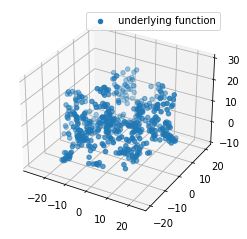

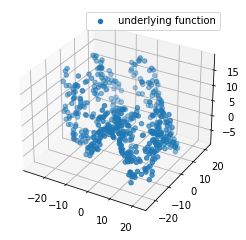

In [5]:
plot_3d(x,y_true[:,0])
plot_3d(x,y_true[:,1])

# Building Neural Net in Tensorflow using Model subclassing 

In [4]:
class Linear(tf.keras.layers.Layer):
  """y = w.x + b"""

  def __init__(self, units=32):
      super(Linear, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

# Model with linear layers with dropout added

In [17]:
class Model(tf.keras.Model):
    """Simple stack of Linear layers."""

    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = Linear(22)
        self.linear2 = Linear(12)
        self.linear3 = Linear(2)

    def call(self, inputs):
        x = self.linear1(inputs)
        x = tf.nn.relu(x)
        x = self.linear2(inputs)
        x = tf.nn.relu(x)
        return self.linear3(x)

# Training Loop with Dropout



In [23]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-308)
loss_fn_mse = tf.keras.losses.MeanSquaredError()

dataset = tf.data.Dataset.from_tensor_slices((x, y_true))
dataset = dataset.shuffle(buffer_size=1).batch(200)

model = Model()

# Iterate over the batches of the dataset.
for step, (x, y) in enumerate(dataset):
  with tf.GradientTape() as tape:
    # Forward Pass
    y_pred = model(x)
    # Compute loss
    loss = loss_fn_mse(y, y_pred)
    loss += sum(model.losses)  # Add regularization loss

  grads = tape.gradient(loss, model.trainable_weights) # Use autograd
  # Update learnable parameter
  optimizer.apply_gradients(
    (grad, var) 
    for (grad, var) in zip(grads, model.trainable_weights)
    if grad is not None
  ) 
  
  if step % 10 == 0:
    print(f'Step: {step}, Loss: {float(loss)}')

Step: 0, Loss: 63.22610855102539


# Post Training Data Visualization

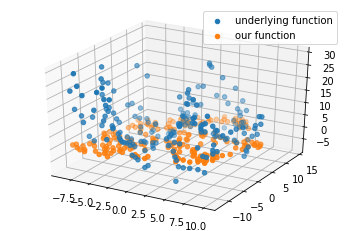

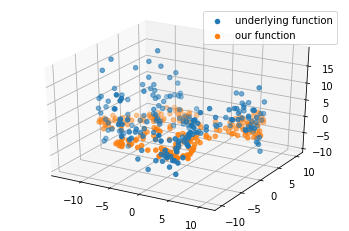

In [25]:
plot_3d(x, y_true[:,0], model(x)[:,0])
plot_3d(x, y_true[:,1], model(x)[:,1])